In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, VotingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import ExtraTreeClassifier, DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from ast import literal_eval
from tqdm import tqdm

In [18]:
tqdm.pandas()

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\tqdm\std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [19]:
songs = pd.read_csv('./data/five_g_500_samp_hpss.csv')

In [20]:
features = songs.columns[22:].drop([])

In [21]:
X = songs[features]
y = songs['genre']

In [42]:
def running_models(X, y):
    # Our features from Spotify are scaled between 0 and 1 already, so we don't need to transform them
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)
    
    # Scale the features
    sc = StandardScaler()
    X_train_sc = sc.fit_transform(X_train)
    X_test_sc = sc.transform(X_test)
    
    # Creating a df to display results
    model_df = pd.DataFrame(columns=['train_score', 'test_score'])
    
    model = SVC(C=.24, kernel='rbf', degree=3)
    model.fit(X_train_sc, y_train)
    train_score = model.score(X_train_sc, y_train)
    test_score = model.score(X_test_sc, y_test)
    
    row = {'model': type(model).__name__,
           'train_score' : train_score,
          'test_score' : test_score}
    model_df = model_df.append(row, ignore_index=True)
    return model_df
    
    

There's a high **positive correlation between loudness and energy** and a high **negative correlation between energy and acousticness**

In [43]:
running_models(X, y)

,train_score,test_score,model
0,0.845333,0.8544,SVC


In [44]:
# Create train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

# Scale the features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [45]:
model = SVC(C=.35)
model.fit(X_train_sc, y_train)

SVC(C=0.35)

In [46]:
categories = list(set(y_preds))
numbers = list(range(5))

NameError: name 'y_preds' is not defined

In [47]:
y_preds = model.predict(X_test_sc)

In [48]:
results = X_test.copy()

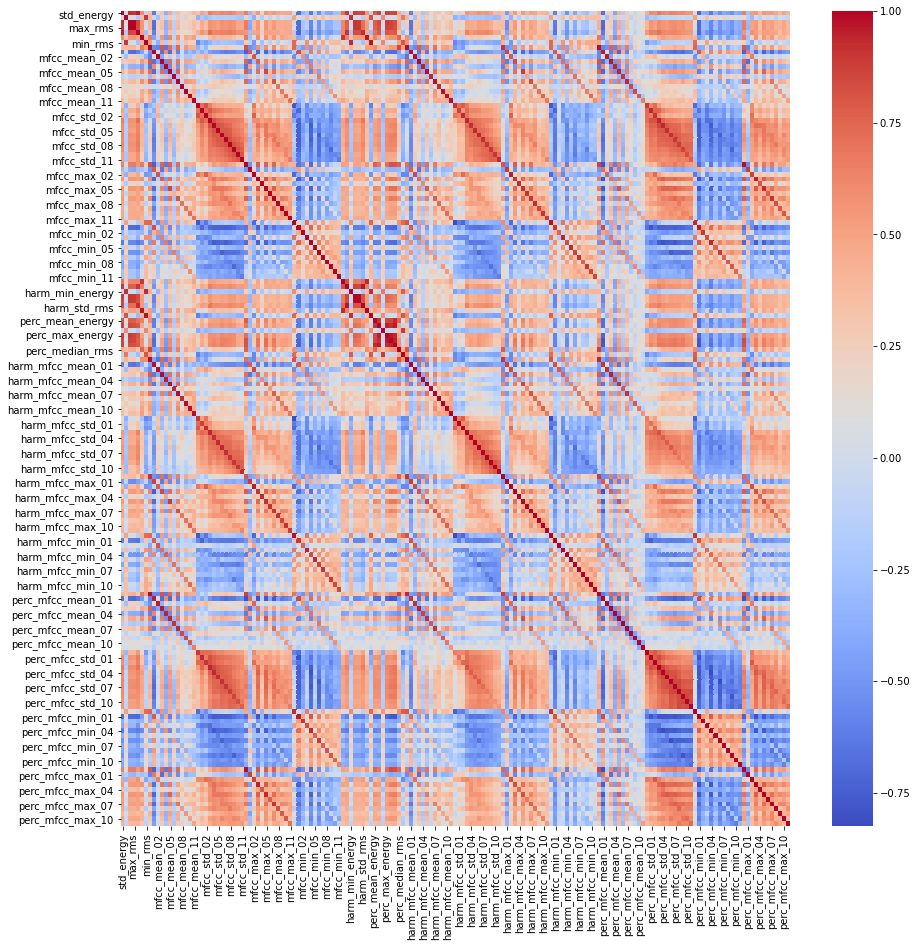

In [49]:
plt.figure(figsize=(15, 15))
sns.heatmap(results.corr(), cmap='coolwarm');

In [50]:
results.loc[:, 'genre'] = y_test.copy()

In [51]:
results.loc[:, 'preds'] = y_preds.copy()

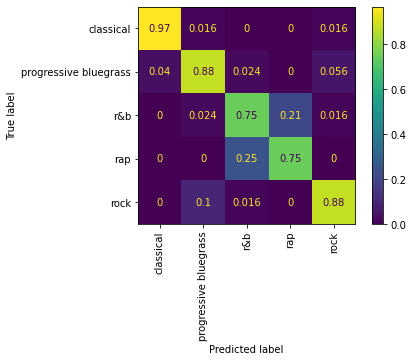

In [52]:
plot_confusion_matrix(model, X_test_sc, y_test, xticks_rotation='vertical', normalize='true');

We can see here that our model performs **best on classical music**, and performs **worst on r&b, only predicting correctly 74% of the time.** I want to dig more into why that is

In [53]:
results_wrong = results[results['genre'] != results['preds']]

In [54]:
songs_wrong = songs.loc[results_wrong.index, ['track_name']]

In [55]:
results_wrong['track_name'] = songs_wrong

C:\ProgramData\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [56]:
results_wrong[(results_wrong['preds'] == 'r&b') & (results_wrong['genre'] == 'rap')].head()

,std_energy,min_energy,max_energy,max_rms,std_rms,median_rms,min_rms,mfcc_mean_00,mfcc_mean_01,mfcc_mean_02,...,perc_mfcc_max_05,perc_mfcc_max_06,perc_mfcc_max_07,perc_mfcc_max_08,perc_mfcc_max_09,perc_mfcc_max_10,perc_mfcc_max_11,genre,preds,track_name
1695,43.958325,0.747842,261.194306,0.714244,0.130822,0.250092,0.038218,-80.160301,142.986038,-25.199087,...,78.474800,37.780125,68.785110,37.742126,42.638580,41.507706,35.320404,rap,r&b,Drowning (feat. Kodak Black)
1653,29.822205,0.227380,231.272377,0.672089,0.110432,0.177969,0.021074,-132.137619,106.776787,-15.860238,...,73.940758,42.289913,46.615746,43.718281,44.083366,30.573662,40.081329,rap,r&b,Only You (feat. The Notorious B.I.G. & Mase) -...
1778,41.379618,0.605496,280.619677,0.740328,0.110651,0.267670,0.034389,-109.434654,109.749611,-21.293751,...,84.378502,55.265358,70.933212,68.202194,43.932068,44.111782,57.102531,rap,r&b,Somethin Tells Me
1534,37.170113,0.440838,342.836105,0.818292,0.107691,0.259776,0.029343,-100.943047,136.709152,-27.925699,...,75.638092,48.519974,55.084045,54.506088,33.377586,44.015213,41.890991,rap,r&b,Cardigan
1856,30.653769,2.283467,236.971450,0.680320,0.092538,0.251618,0.066782,-85.101601,125.324379,-24.208700,...,87.176651,63.198647,59.439735,46.887146,45.934845,32.519978,33.273232,rap,r&b,Sky's the Limit (feat. 112) - 2014 Remaster


In [57]:
group_preds = results_wrong.groupby('preds').mean()

In [58]:
# Getting columns where rap and r&b are very close to each other
group_preds.columns[abs(group_preds.loc['rap']) - abs(group_preds.loc['r&b']) < 0.001]

Index(['min_energy', 'min_rms', 'mfcc_mean_01', 'mfcc_mean_02', 'mfcc_mean_04',
       'mfcc_mean_06', 'mfcc_mean_07', 'mfcc_mean_08', 'mfcc_mean_09',
       'mfcc_min_01', 'mfcc_min_06', 'mfcc_min_08', 'harm_min_energy',
       'harm_min_rms', 'perc_min_energy', 'perc_median_rms', 'perc_min_rms',
       'harm_mfcc_mean_01', 'harm_mfcc_mean_02', 'harm_mfcc_mean_04',
       'harm_mfcc_mean_06', 'harm_mfcc_mean_07', 'harm_mfcc_max_01',
       'harm_mfcc_min_01', 'harm_mfcc_min_06', 'harm_mfcc_min_08',
       'perc_mfcc_mean_01', 'perc_mfcc_mean_02', 'perc_mfcc_mean_04',
       'perc_mfcc_mean_06', 'perc_mfcc_mean_07', 'perc_mfcc_mean_08',
       'perc_mfcc_mean_10', 'perc_mfcc_min_08'],
      dtype='object')

In [59]:
results_wrong['genre'].value_counts(normalize=True)

r&b                      0.322917
rap                      0.322917
rock                     0.156250
progressive bluegrass    0.156250
classical                0.041667
Name: genre, dtype: float64

Rap and R&B seem to be predicted wrong most often with these new features I've pulled

In [60]:
results_wrong[results_wrong['genre'] == 'rap']['preds'].value_counts(normalize=True)

r&b    1.0
Name: preds, dtype: float64

It seems that when Rap is predicted wrong, it's predicted as r&b.

In [61]:
results_wrong[results_wrong['genre'] == 'r&b']['preds'].value_counts(normalize=True)

rap                      0.838710
progressive bluegrass    0.096774
rock                     0.064516
Name: preds, dtype: float64

When R&B is predicted wrong, it's predicted to be rap 84% of the time

In [62]:
genre_mean = songs.groupby('genre').mean()

Interesting that most of the genres hover slightly above 120 as a tempo. There's some interesting reasoning behind this with commercial music and the need for 30-seconds of music to fill an advertising slot. 128 beats per minute would allow for a 16-bar phrase in 4/4 time.

In [63]:
X = songs[features]
# Thanks joris on SO: https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969
y_cat = songs['genre'].astype('category').cat.codes

In [64]:
y = to_categorical(y_cat)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=182)

In [66]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [79]:
fnn_model = Sequential()

fnn_model.add(Dense(8, activation='relu', input_shape=(X_train_sc.shape[1],)))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(16, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(8, activation='relu'))
fnn_model.add(Dropout(0.5))
fnn_model.add(Dense(5, activation='softmax'))

fnn_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

hist = fnn_model.fit(X_train_sc, y_train,
                epochs=100,
                batch_size=128,
                validation_data=(X_test_sc, y_test),
                    use_multiprocessing=True,
                    verbose=1)

Epoch 1/100
15/15 [==============================] - 0s 7ms/step - loss: 1.6030 - acc: 0.2389 - val_loss: 1.5231 - val_acc: 0.3184
Epoch 2/100
15/15 [==============================] - 0s 3ms/step - loss: 1.5064 - acc: 0.2912 - val_loss: 1.3980 - val_acc: 0.4096
Epoch 3/100
15/15 [==============================] - 0s 2ms/step - loss: 1.4211 - acc: 0.3173 - val_loss: 1.2748 - val_acc: 0.4608
Epoch 4/100
15/15 [==============================] - 0s 2ms/step - loss: 1.3859 - acc: 0.3355 - val_loss: 1.1963 - val_acc: 0.5088
Epoch 5/100
15/15 [==============================] - 0s 2ms/step - loss: 1.3296 - acc: 0.3771 - val_loss: 1.1462 - val_acc: 0.5424
Epoch 6/100
15/15 [==============================] - 0s 2ms/step - loss: 1.3059 - acc: 0.3707 - val_loss: 1.1062 - val_acc: 0.5568
Epoch 7/100
15/15 [==============================] - 0s 2ms/step - loss: 1.2653 - acc: 0.4027 - val_loss: 1.0639 - val_acc: 0.5696
Epoch 8/100
15/15 [==============================] - 0s 2ms/step - loss: 1.2459 - a

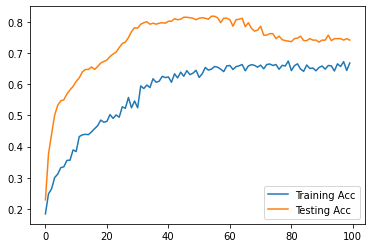

In [78]:
plt.plot(hist.history['acc'], label="Training Acc")
plt.plot(hist.history['val_acc'], label="Testing Acc")
plt.legend();

With my extracted features (energy, rms, and mfcc), I'm able to improve on the accuracy of the spotify model by **5-7% on training data**
* SVC model $\approx 84\%$ accuracy
* FNN model $\approx 82\%$ accuracy

## What's next?

I still want to find some way for the model to be able to tell the difference between rap and r&b